**NOTE**

This is a *draft* version of the notebook that is used for the workshop, and includes a lot of scratch work that was done to chart a path from the Census Data API web page through to reproducting the 2021 data in the 2022 press release on educational attainment and the corresponding infographic. 

This notebook has been retained to document a messy process. For the finished process, see the notebook in this repository, *Census-API-Tutorial.*

# Census APIs

Request a key at <https://api.census.gov/data/key_signup.html>

An email will be sent to the addres you provide. The email will include a link to activate the key. It may take a few minutes before the key can be activated.

In [326]:
# Load API key

# Note the file with the API key is not in the GitHub repo.
# Keys need to be read from a local directory
with open("jwCensusApi", "r") as i:
    key = i.read()

In [327]:
import json
import requests
import pandas as pd
import matplotlib as plt

In [328]:
'''
Current Population Survey Annual Social and Economic Supplement
https://api.census.gov/data.html

Vars: https://api.census.gov/data/2021/cps/asec/mar/variables.html
'''

endpoint = "http://api.census.gov/data/2021/cps/asec/mar" # state geographies
ex1_url = "https://api.census.gov/data/2021/cps/asec/mar?get=NOW_COV,MARSUPWT,A_MARITL&for=state:35&A_HGA=39"
ex2_url = "https://api.census.gov/data/2021/cps/asec/mar?tabulate=weight(MARSUPWT)&col+NOW_COV&row+A_MARITL&for=state:35&A_HGA=39"

In [329]:
api_request_url = ex1_url + "&key=" + key
api_request = requests.get(api_request_url)

In [330]:
api_json = api_request.json()

In [331]:
# print(json.dumps(api_json, indent=4)) # long output

## Identifying the Data Source

We are going to use the Census API to retrieve data to reproduce some of the statistics from the Feb 24, 2022, press release and infographic *A Higher Degree.*

**Press release:** <https://www.census.gov/newsroom/press-releases/2022/educational-attainment.html>

**Infographic:** <https://www.census.gov/library/visualizations/2022/comm/a-higher-degree.html>

Below is the infographic. Note that for today's workshop we are using only 2021 data.

<a class="embeddable-image__embedLink" href="https://www.census.gov/library/visualizations/2022/comm/a-higher-degree.html?cid=higher-degree" target="_blank"><img class="embeddable-image__embedImage" data-src="/library/visualizations/2022/comm/a-higher-degree/_jcr_content/root/responsivegrid/embeddableimage1119.coreimg.jpeg/1645624284211/educational-attainment-2022.jpeg" alt="A Higher Degree" title="A Higher Degree" src="https://www.census.gov/library/visualizations/2022/comm/a-higher-degree/_jcr_content/root/responsivegrid/embeddableimage1119.coreimg.jpeg/1645624284211/educational-attainment-2022.jpeg" width="1080" height="1080"></a>[Source: U.S. Census Bureau]

According to the press release, the data are from the *2000–2002 March Current Population Survey and 2003–2021 Annual Social and Economic Supplement to the Current Population Survey.*

### Q: How to get info on variables via API?

We can look it up online, but we may also get this info dynamically. 

#### Steps:

1. Go to the *Census Data API Discovery Tool*: <https://www.census.gov/data/developers/updates/new-discovery-tool.html>
1. Preview the datasets and available information using the HTML format: <https://api.census.gov/data.html>
1. Using a process similar to the above, we can also retrieve the information in JSON format.

In [332]:
# Request the JSON information about available datasets

datasets_url = "https://api.census.gov/data.json"
datasets_request = requests.get(datasets_url)
datasets_json = datasets_request.json()

In [333]:
# this took a little sleuthing...

# Get the titles of the datasets
dataset_list = datasets_json["dataset"]

# title: Current Population Survey Annual Social and Economic Supplement
# c_vintage: 2021
# id: https://api.census.gov/data/id/CPSASEC2021

cpd_asec_mar = [d for d in dataset_list if d["identifier"] == "https://api.census.gov/data/id/CPSASEC2021"]
print(json.dumps(cpd_asec_mar, indent=4)) # long output

[
    {
        "c_vintage": 2021,
        "c_dataset": [
            "cps",
            "asec",
            "mar"
        ],
        "c_geographyLink": "http://api.census.gov/data/2021/cps/asec/mar/geography.json",
        "c_variablesLink": "http://api.census.gov/data/2021/cps/asec/mar/variables.json",
        "c_tagsLink": "http://api.census.gov/data/2021/cps/asec/mar/tags.json",
        "c_examplesLink": "http://api.census.gov/data/2021/cps/asec/mar/examples.json",
        "c_groupsLink": "http://api.census.gov/data/2021/cps/asec/mar/groups.json",
        "c_sorts_url": "http://api.census.gov/data/2021/cps/asec/mar/sorts.json",
        "c_valuesLink": "http://api.census.gov/data/2021/cps/asec/mar/values.json",
        "c_documentationLink": "https://www.census.gov/developer/",
        "c_isMicrodata": true,
        "c_isCube": true,
        "c_isAvailable": true,
        "@type": "dcat:Dataset",
        "title": "Current Population Survey Annual Social and Economic Supplement",
   

In [334]:
# Get info on variables

dataset_vars_url = cpd_asec_mar[0]["c_variablesLink"]
dataset_vars_request = requests.get(dataset_vars_url)
datasets_vars_json = dataset_vars_request.json()
# print(json.dumps(datasets_vars_json, indent=4)) # long output - many variables
# just print the variable and the label
dataset_vars = datasets_vars_json["variables"]
# sort variable names
sorted_vars = sorted(dataset_vars.keys())
for k in sorted_vars[:10]:
    var_info = dataset_vars[k]
    print(k, ":", var_info["label"])

ACTC_CRD : additional chld tax credit
AGE1 : Demographics, Age recode, persons 15+ years
AGI : Federal adjusted gross income
ANN_VAL : Retirement income, annuities amount
ANN_YN : Retirement income, annuities, y/n
AXAGE : Allocation flag for A_AGE
AXCLSWKR : Allocation flag for A_CLSWKR
AXENRLW : Allocation flag for A_ENRLW
AXFTPT : Allocation flag for A_FTPT
AXHGA : Allocation flag for A_HGA


In [335]:
# Maybe create dictionaries of vars:defs
# populate via iteration

var = "NOW_COV"
var_def_url = endpoint + "/variables/" + var

In [336]:
var_def_request = requests.get(var_def_url)

In [337]:
var_json = var_def_request.json()

In [338]:
print(json.dumps(var_json, indent=4))

{
    "name": "NOW_COV",
    "label": "Currently covered by health insurance coverage",
    "predicateType": "int",
    "group": "N/A",
    "limit": 0,
    "suggested-weight": "MARSUPWT",
    "values": {
        "item": {
            "2": "No",
            "1": "Yes"
        }
    }
}


In [339]:
'''
Variables of interest

A_HGA - educational attainment
AGE1 - age
AGI - federal adjusted gross income

NM FIPS ID = 35
'''

vars_list = ["A_HGA", "AGE1", "AGI"]
vars_dict = {}

for v in vars_list:
    var_def_url = endpoint + "/variables/" + v
    var_def_request = requests.get(var_def_url)
    var_json = var_def_request.json()
    vars_dict[v] = var_json

In [340]:
vars_dict

{'A_HGA': {'name': 'A_HGA',
  'label': 'Demographics, Educational attainment',
  'predicateType': 'int',
  'group': 'N/A',
  'limit': 0,
  'suggested-weight': 'MARSUPWT',
  'values': {'item': {'35': '9th Grade',
    '41': 'Assc degree-occupation/vocation',
    '0': 'Children',
    '31': 'Less Than 1st Grade',
    '44': "Master's degree (MA,MS,MENG,MED,MSW,MBA)",
    '43': "Bachelor's degree (BA,AB,BS)",
    '34': '7th and 8th grade',
    '38': '12th Grade No Diploma',
    '37': '11th Grade',
    '33': '5th Or 6th Grade',
    '45': 'Professional school degree (MD,DDS,DVM,L',
    '39': 'High school graduate-high school diploma',
    '32': '1st,2nd,3rd,or 4th grade',
    '40': 'Some College But No Degree',
    '46': 'Doctorate degree (PHD,EDD)',
    '36': '10th Grade',
    '42': 'Assc degree-academic program'}}},
 'AGE1': {'name': 'AGE1',
  'label': 'Demographics, Age recode, persons 15+ years',
  'predicateType': 'int',
  'group': 'N/A',
  'limit': 0,
  'suggested-weight': 'MARSUPWT',
  

In [341]:
# API expects vars to be comma separated, no spaces

vars_query = ','.join(str(v) for v in vars_list)
print(vars_query)

A_HGA,AGE1,AGI


In [342]:
# request non-tabulated data
# URL format: "https://api.census.gov/data/2021/cps/asec/mar?get=NOW_COV,MARSUPWT,A_MARITL&for=state:35"

# We can parameterize the state but for now we will hard code all and NM (35)
api_request_url = endpoint + "?get=" + vars_query + "&for=state:*&key=" + key
api_request = requests.get(api_request_url)
api_json = api_request.json()

In [343]:
type(api_json) # results seem to generally be lists, but check in case a dictionary is returned

list

In [344]:
census_df = pd.read_json(json.dumps(api_json), typ = "frame", orient = "values")

In [345]:
census_df.head()

,0,1,2,3
0,A_HGA,AGE1,AGI,state
1,39,12,10000,23
2,39,12,0,23
3,39,17,0,23
4,43,15,80819,23


In [346]:
census_df.columns = census_df.iloc[0]

In [347]:
census_df.head()

,A_HGA,AGE1,AGI,state
0,A_HGA,AGE1,AGI,state
1,39,12,10000,23
2,39,12,0,23
3,39,17,0,23
4,43,15,80819,23


In [348]:
census_df = census_df.drop(census_df.index[0])

In [349]:
census_df.head()

,A_HGA,AGE1,AGI,state
1,39,12,10000,23
2,39,12,0,23
3,39,17,0,23
4,43,15,80819,23
5,39,15,0,23


In [350]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163543 entries, 1 to 163543
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   A_HGA   163543 non-null  object
 1   AGE1    163543 non-null  object
 2   AGI     163543 non-null  object
 3   state   163543 non-null  object
dtypes: object(4)
memory usage: 6.2+ MB


In [351]:
# We can separately request data for just NM, or we can subset
# recall that the FIPS code for NM is 35

nm_census_data = census_df[census_df["state"] == "35"].copy() # quotes around "35" b/c it is an object not an int

In [352]:
nm_census_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2900 entries, 126038 to 128937
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   A_HGA   2900 non-null   object
 1   AGE1    2900 non-null   object
 2   AGI     2900 non-null   object
 3   state   2900 non-null   object
dtypes: object(4)
memory usage: 113.3+ KB


In [353]:
# out of curiosity let's get the NM data via API
# same as before with one different parameter

api_request_url = endpoint + "?get=" + vars_query + "&for=state:35&key=" + key
api_request = requests.get(api_request_url)
api_json = api_request.json()

nm_census_df = pd.read_json(json.dumps(api_json), typ = "frame", orient = "values")
nm_census_df.columns = nm_census_df.iloc[0]
nm_census_df = nm_census_df.drop(nm_census_df.index[0])

In [354]:
nm_census_df.info() # the data have the same number of rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2900 entries, 1 to 2900
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   A_HGA   2900 non-null   object
 1   AGE1    2900 non-null   object
 2   AGI     2900 non-null   object
 3   state   2900 non-null   object
dtypes: object(4)
memory usage: 113.3+ KB


In [355]:
# Let's make a function to get the data and convert to data frame
# "https://api.census.gov/data/2021/cps/asec/mar?tabulate=weight(MARSUPWT)&col+NOW_COV&row+A_MARITL&for=state:35&A_HGA=39"
def get_census_data(endpoint_url, vars_list, key, state = "*"):
    # First, convert vars_list to string
    vars_query = ','.join(str(v) for v in vars_list)
    
    # Build the request URL
    api_request_url = endpoint_url + "?get=" + vars_query + "&for=state:" + state + "&key=" + key
    
    # Request the data
    api_request = requests.get(api_request_url)
    api_json = api_request.json()
    
    # Convert returned JSON to dataframe
    df = pd.read_json(json.dumps(api_json), typ = "frame", orient = "values")
    
    # Use first row values for col headers
    df.columns = df.iloc[0]
    
    # Drop first row, which is still header info
    df = df.drop(df.index[0])
    
    return df

# While we're at it, create a function to get var defs
# No key needed
def get_census_vars(vars_list):
    vars_dict = {}
    for v in vars_list:
        var_def_url = endpoint + "/variables/" + v
        var_def_request = requests.get(var_def_url)
        var_json = var_def_request.json()
        vars_dict[v] = var_json
    return vars_dict

In [356]:
# Now we can make ad hoc requests
# but we will redo our initial request

vars_list = ["A_HGA", "AGE1", "AGI"]
var_info = get_census_vars(vars_list)
census_data = get_census_data(endpoint, vars_list, key) # use default * for all state data

In [357]:
census_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163543 entries, 1 to 163543
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   A_HGA   163543 non-null  object
 1   AGE1    163543 non-null  object
 2   AGI     163543 non-null  object
 3   state   163543 non-null  object
dtypes: object(4)
memory usage: 6.2+ MB


In [358]:
# try again with just NM
# census_data = get_census_data(endpoint, vars_list, key, state = "35") # NM
# census_data.info()

In [359]:
# Things work - let's see about reproducing stats from the press release
# Right now we have age and education attainment (and income) for 2021

'''
In 2021, the highest level of education of the population age 25 and older in the United States 
was distributed as follows: 

    8.9% had less than a high school diploma or equivalent.
    27.9% had high school graduate as their highest level of school completed. 
    14.9% had completed some college but not a degree.
    10.5% had an associate degree as their highest level of school completed.
    23.5% had a bachelor’s degree as their highest degree.
    14.4% had completed an advanced degree such as a master’s degree, professional degree or doctoral degree. 
'''

var_info

{'A_HGA': {'name': 'A_HGA',
  'label': 'Demographics, Educational attainment',
  'predicateType': 'int',
  'group': 'N/A',
  'limit': 0,
  'suggested-weight': 'MARSUPWT',
  'values': {'item': {'35': '9th Grade',
    '41': 'Assc degree-occupation/vocation',
    '0': 'Children',
    '31': 'Less Than 1st Grade',
    '44': "Master's degree (MA,MS,MENG,MED,MSW,MBA)",
    '43': "Bachelor's degree (BA,AB,BS)",
    '34': '7th and 8th grade',
    '38': '12th Grade No Diploma',
    '37': '11th Grade',
    '33': '5th Or 6th Grade',
    '45': 'Professional school degree (MD,DDS,DVM,L',
    '39': 'High school graduate-high school diploma',
    '32': '1st,2nd,3rd,or 4th grade',
    '40': 'Some College But No Degree',
    '46': 'Doctorate degree (PHD,EDD)',
    '36': '10th Grade',
    '42': 'Assc degree-academic program'}}},
 'AGE1': {'name': 'AGE1',
  'label': 'Demographics, Age recode, persons 15+ years',
  'predicateType': 'int',
  'group': 'N/A',
  'limit': 0,
  'suggested-weight': 'MARSUPWT',
  

In [360]:
# First subset to AGE1 values >= 6 (25 and older)

# convert cols to int
census_data = census_data.astype(int)
census_data.info()
age_gte25 = census_data[census_data["AGE1"] >= 6].copy()
age_gte25.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163543 entries, 1 to 163543
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   A_HGA   163543 non-null  int32
 1   AGE1    163543 non-null  int32
 2   AGI     163543 non-null  int32
 3   state   163543 non-null  int32
dtypes: int32(4)
memory usage: 3.7 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 108998 entries, 1 to 163543
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   A_HGA   108998 non-null  int32
 1   AGE1    108998 non-null  int32
 2   AGI     108998 non-null  int32
 3   state   108998 non-null  int32
dtypes: int32(4)
memory usage: 2.5 MB


In [361]:
age_gte25.head()

,A_HGA,AGE1,AGI,state
1,39,12,10000,23
2,39,12,0,23
3,39,17,0,23
4,43,15,80819,23
5,39,15,0,23


In [362]:
var_info

{'A_HGA': {'name': 'A_HGA',
  'label': 'Demographics, Educational attainment',
  'predicateType': 'int',
  'group': 'N/A',
  'limit': 0,
  'suggested-weight': 'MARSUPWT',
  'values': {'item': {'35': '9th Grade',
    '41': 'Assc degree-occupation/vocation',
    '0': 'Children',
    '31': 'Less Than 1st Grade',
    '44': "Master's degree (MA,MS,MENG,MED,MSW,MBA)",
    '43': "Bachelor's degree (BA,AB,BS)",
    '34': '7th and 8th grade',
    '38': '12th Grade No Diploma',
    '37': '11th Grade',
    '33': '5th Or 6th Grade',
    '45': 'Professional school degree (MD,DDS,DVM,L',
    '39': 'High school graduate-high school diploma',
    '32': '1st,2nd,3rd,or 4th grade',
    '40': 'Some College But No Degree',
    '46': 'Doctorate degree (PHD,EDD)',
    '36': '10th Grade',
    '42': 'Assc degree-academic program'}}},
 'AGE1': {'name': 'AGE1',
  'label': 'Demographics, Age recode, persons 15+ years',
  'predicateType': 'int',
  'group': 'N/A',
  'limit': 0,
  'suggested-weight': 'MARSUPWT',
  

In [363]:
# convert A_HGA, AGE1, and state to categories
age_gte25.A_HGA = age_gte25.A_HGA.astype("category")
age_gte25.AGE1 = age_gte25.AGE1.astype("category")
age_gte25.state = age_gte25.state.astype("category")

In [364]:
age_gte25.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108998 entries, 1 to 163543
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   A_HGA   108998 non-null  category
 1   AGE1    108998 non-null  category
 2   AGI     108998 non-null  int32   
 3   state   108998 non-null  category
dtypes: category(3), int32(1)
memory usage: 1.6 MB


In [365]:
type(age_gte25.iloc[0, 0])

numpy.int64

In [366]:
age_gte25.iloc[0, 0]

39

In [367]:
# so cols are categories but cell values are still int (?)

# Educational attainment: <= 38 less than HS diploma or eq
# 39 == HS diploma, 40 == some college ND, 41 & 42 == assoc Deg, 43 == Bachelor's, 
# 44 & 45 Masters or professional degree, 46 == doctorate

# there is probably a faster way to do this
ed_groups = age_gte25.groupby("A_HGA")

In [368]:
#ed_groups.groups

In [369]:
# 27.9% HS grads per press release
hs_grads = ed_groups.get_group(39)

In [370]:
len(hs_grads)

30656

In [371]:
(30656 / 108998) * 100

28.1252867025083

In [372]:
# 14.9% had some college

some_college_nd = ed_groups.get_group(40)

In [373]:
len(some_college_nd)

16369

In [374]:
(16369/108998) * 100

15.017706746912788

In [375]:
# 31-38 for no HS
# 8.9% report less than HS diploma or eq

no_diploma = 0
for i in range(31, 39):
    g = ed_groups.get_group(i)
    no_diploma += len(g)

In [376]:
no_diploma

10289

In [377]:
(10289/108998) * 100

9.439622745371475

In [378]:
# Values are different from press release - try weighted data

census_wtd_url = "https://api.census.gov/data/2021/cps/asec/mar?tabulate=weight(MARSUPWT)&col+A_HGA&row+AGE1&for=state:*"

In [379]:
census_wtd_request = requests.get(census_wtd_url)

In [380]:
census_wtd_json = census_wtd_request.json()

In [381]:
#print(json.dumps(census_wtd_json, indent=4)) # long output

In [382]:
# Convert returned JSON to dataframe
drop_keys = census_wtd_json[1:]
get_keys = census_wtd_json[0]
w_df = pd.read_json(json.dumps(drop_keys), typ = "frame", orient = "values")
cols = []
for k in get_keys:
    if isinstance(k, dict):
        v = [e[:] for e in k.values()]
        cols.append(v[0])
    if isinstance(k, str):
        cols.append(k)
w_df.columns = cols
w_df.set_index("AGE1", inplace = True)
print(w_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 9 to 17
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   35      18 non-null     int64
 1   41      18 non-null     int64
 2   0       18 non-null     int64
 3   31      18 non-null     int64
 4   44      18 non-null     int64
 5   43      18 non-null     int64
 6   34      18 non-null     int64
 7   38      18 non-null     int64
 8   37      18 non-null     int64
 9   33      18 non-null     int64
 10  45      18 non-null     int64
 11  39      18 non-null     int64
 12  32      18 non-null     int64
 13  40      18 non-null     int64
 14  46      18 non-null     int64
 15  36      18 non-null     int64
 16  42      18 non-null     int64
dtypes: int64(17)
memory usage: 2.5 KB
None


In [383]:
w_df.sort_index(inplace = True)

In [384]:
w_df.head()

,35,41,0,31,44,43,34,38,37,33,45,39,32,40,46,36,42
AGE1,,,,,,,,,,,,,,,,,
0,0,0,59938081,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1681838,729,0,4907,1979,5403,1588774,18507,89172,16646,0,50480,0,34640,0,672541,7567
2,1848048,7409,0,18881,3715,38273,227935,437006,2372533,23064,0,270160,19653,110498,1077,3282559,5421
3,92328,40503,0,13448,4965,48576,51529,644884,1782967,10011,0,2553580,5496,2210180,2563,266806,88093
4,51054,171027,0,15589,16770,222168,57125,202790,206899,7866,0,2919202,6153,4163847,0,85361,353451


In [385]:
w_df.loc[6:]

,35,41,0,31,44,43,34,38,37,33,45,39,32,40,46,36,42
AGE1,,,,,,,,,,,,,,,,,
6,186793,903353,0,35343,1752186,6668554,127343,285213,354979,91872,200201,6304709,23674,3891482,185560,175782,1405260
7,265218,973138,0,34359,2555902,6368638,192550,279557,354031,162482,311814,5627420,51778,3437538,454176,230976,1391684
8,310629,876556,0,47813,2714555,5746319,279523,270560,300046,277076,379479,5002109,99229,3083392,544623,292238,1383291
9,314869,914820,0,34124,2658149,5036686,298526,283375,282743,307977,394458,5039375,112508,2743662,468306,269929,1237130
10,236174,926925,0,70614,2426865,4735305,264782,195381,265097,302186,343381,4910132,102854,2618376,490813,254245,1263333
11,288878,887994,0,79748,2348562,4986696,292745,226746,264511,243927,283845,5508656,124581,2772182,488343,222810,1253221
12,259796,1083822,0,56009,1978130,4485108,268934,258558,342008,279915,280215,6146782,168202,2977981,402983,328561,1365380
13,86710,455648,0,38175,842147,1739547,114680,102333,186219,115182,101909,2741130,64194,1301734,143156,120957,523512
14,155248,566989,0,57663,1132473,2643972,148280,141625,207214,176266,154738,3840281,96105,1894950,257253,154101,789906


In [386]:
w_df.to_numpy().sum()

326195440

In [387]:
w_df[6:].to_numpy().sum()

224580155

In [388]:
sum_age_gte25 = w_df[6:].to_numpy().sum()

In [389]:
# all pop >= 25, HS diploma only (A_HGA == 39)
w_df[6:]["39"]

AGE1
6     6304709
7     5627420
8     5002109
9     5039375
10    4910132
11    5508656
12    6146782
13    2741130
14    3840281
15    5414577
16    4205280
17    7806866
Name: 39, dtype: int64

In [390]:
w_df[6:]["39"].sum()

62547317

In [391]:
hs_diploma = w_df[6:]["39"].sum()

In [392]:
round((hs_diploma/sum_age_gte25) * 100, 1) # This is the correct %

27.9

In [393]:
# some college, no degree (40)
round((w_df[6:]["40"].sum()/sum_age_gte25) * 100, 1) # also the correct &

14.9

In [394]:
# no HS diploma
no_hs_diploma = w_df[6:][["31", "32", "33", "34", "35", "36", "37", "38"]].to_numpy().sum()

In [395]:
no_hs_diploma

20054210

In [396]:
round((no_hs_diploma/sum_age_gte25) * 100, 1) # also correct

8.9

<AxesSubplot:xlabel='AGE1'>

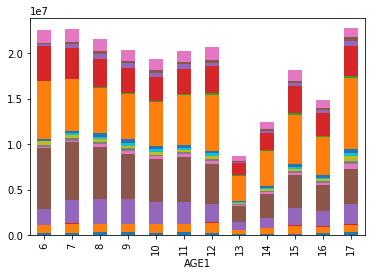

In [397]:
w_df[6:].plot.bar(stacked = True, legend = False) # ed attainment stacked bar plot (x = age, y = count)

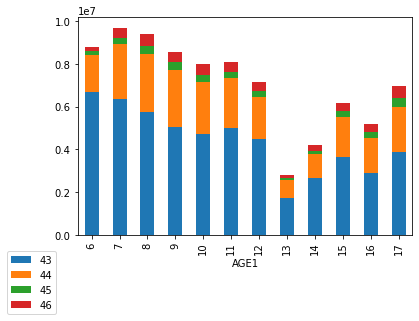

In [398]:
'''
    '44': "Master's degree (MA,MS,MENG,MED,MSW,MBA)",
    '43': "Bachelor's degree (BA,AB,BS)",
    '45': 'Professional school degree (MD,DDS,DVM,L',
    '46': 'Doctorate degree (PHD,EDD)',
'''
w_df[6:][["43", "44", "45", "46"]].plot.bar(stacked = True).legend(loc = "best", bbox_to_anchor = (-0.05, -0.05))

<AxesSubplot:>

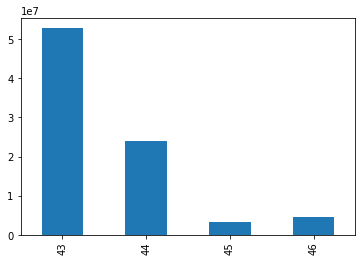

In [399]:
w_df[6:][["43", "44", "45", "46"]].sum().plot.bar(legend = False) # close! - y scale is 10m

In [400]:
w_df[6:][["43", "44", "45", "46"]].sum()

43    52805178
44    24058725
45     3443225
46     4729870
dtype: int64

In [401]:
plot_data = pd.DataFrame(w_df[6:][["43", "44", "45", "46"]].sum())

In [402]:
type(plot_data)

pandas.core.frame.DataFrame

In [403]:
plot_data

,0
43,52805178
44,24058725
45,3443225
46,4729870


In [404]:
plot_data.columns = ["2021"]

In [405]:
round(plot_data.iloc[0]["2021"]/1000000, 1)

52.8

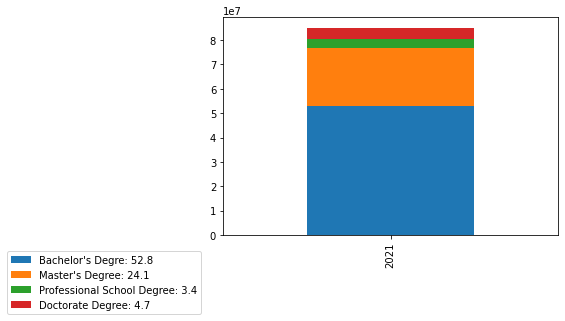

In [406]:
l = ["Bachelor's Degre: " + str(round(plot_data.iloc[0]["2021"]/1000000, 1)), 
     "Master's Degree: " + str(round(plot_data.iloc[1]["2021"]/1000000, 1)), 
     "Professional School Degree: " + str(round(plot_data.iloc[2]["2021"]/1000000, 1)),
     "Doctorate Degree: " + str(round(plot_data.iloc[3]["2021"]/1000000, 1))]
plot_data.T.plot.bar(stacked=True).legend(l, loc = "best", bbox_to_anchor = (-0.05, -0.05))